# Sentiment Analysis on Movie Reviews
## Classify the sentiment of sentences from the Rotten Tomatoes dataset

In this Kaggle project, I attempt to classify the sentiment of sentences from the Rotten Tomatoes dataset using several feature engineering (tokenisation, cleaning the text and removing stop words, using Word2vec embedding, lematization and normalisation) and Recurrent Neural Netorks (LSTM). Because removing too many stop words slightly decreased validation performance for the majority of models, I chose to only remove punctuation and some common articles (such as "a", "an"), to only use lowercase writing and to apply lematization. Before applying the Word2vec embedding on the data, I first updated the weights of the word vectors with the Google News corpus. This improved the accuracy by roughly 5% -6%. Normalisation (min-max scaling) further improved the accuracy of the model (in this case close to 10%). 

The sentiment labels are:

0. negative
1. somewhat negative
2. neutral
3. somewhat positive
4. positive

The workflow consists of the following steps:


* Exploring the data and creating new features
* Pre-processing and vectorization
* Developing a classifier for predicting the sentiment

First, I will import all the packages necessary for visualisation and pre-processing and set my working directory.


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from textblob import TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
warnings.filterwarnings(action = 'ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
training = pd.read_csv("/content/train.tsv", sep='\t')
test = pd.read_csv("/content/test.tsv", sep='\t')

In [3]:
%matplotlib inline
training.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Exploring the data and creating new features

In order to explore the data and perform further transformations, I will first join the training and testing datasets.

In [5]:
training['train_test'] = 1
test['train_test'] = 0
test['Sentiment'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

pd.set_option('display.max_colwidth', 100000)

all_data.Phrase=all_data.Phrase.str.strip()

In [6]:
all_data.head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1
2,3,1,A series,2.0,1
3,4,1,A,2.0,1
4,5,1,series,2.0,1
5,6,1,of escapades demonstrating the adage that what is good for the goose,2.0,1
6,7,1,of,2.0,1
7,8,1,escapades demonstrating the adage that what is good for the goose,2.0,1
8,9,1,escapades,2.0,1
9,10,1,demonstrating the adage that what is good for the goose,2.0,1


In [7]:
training.shape

(156060, 5)

Let us  is now create a frequency count for the Sentiment column.

In [8]:
all_data.Sentiment.value_counts()

2.0    79582
3.0    32927
1.0    27273
4.0     9206
0.0     7072
Name: Sentiment, dtype: int64

2.0    0.357910
3.0    0.148085
1.0    0.122657
4.0    0.041403
0.0    0.031805
Name: Sentiment, dtype: float64


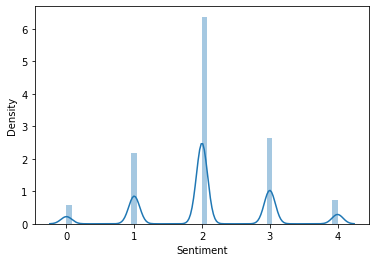

In [9]:
print(all_data.Sentiment.value_counts() / len(all_data))

%matplotlib inline
sns.distplot(all_data.loc[all_data['train_test']==1,"Sentiment"])

The majority of reviews (around 36%) are neutral. 

In [10]:
word_tokens = [word_tokenize(review.lower()) for review in all_data.Phrase]

print(word_tokens[0:5])

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], ['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series'], ['a'], ['series']]


In [11]:
len_tokens = []

# Iterate over the word_tokens list
for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))
    
all_data['n_tokens'] = len_tokens

In [12]:
all_data.sort_values(by='n_tokens', ascending=False).head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens
3776,159837,8685,"The film is faithful to what one presumes are the book 's twin premises -- that we become who we are on the backs of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious commodity no matter how old you are .",NaN,0,56
3777,159838,8685,"The film is faithful to what one presumes are the book 's twin premises -- that we become who we are on the backs of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious commodity no matter how old you are",NaN,0,55
18578,18579,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie .",1.0,1,53
18579,18580,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie",1.0,1,52
75357,75358,3866,"Build some robots , haul 'em to the theatre with you for the late show , and put on your own Mystery Science Theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year .",0.0,1,52
35598,35599,1678,"It cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .",4.0,1,52
87835,87836,4563,"There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .",4.0,1,52
105155,105156,5555,"... spiced with humor -LRB- ' I speak fluent flatula , ' advises Denlopp after a rather , er , bubbly exchange with an alien deckhand -RRB- and witty updatings -LRB- Silver 's parrot has been replaced with Morph , a cute alien creature who mimics everyone and everything around -RRB-",3.0,1,51
59649,59650,3010,"It 's a bad sign when you 're rooting for the film to hurry up and get to its subjects ' deaths just so the documentary will be over , but it 's indicative of how uncompelling the movie is unless it happens to cover your particular area of interest .",0.0,1,51
80457,80458,4145,"If S&M seems like a strange route to true love , maybe it is , but it 's to this film 's -LRB- and its makers ' -RRB- credit that we believe that that 's exactly what these two people need to find each other -- and themselves .",3.0,1,51


The new columns created consist of Polarity, Subjectivity and the number of tokens (nb. of words per observation). Polarity ranges between -1 and 1; with a polarity greater than 0.5 illustrating a positive sentiment, a polarity lower than -0.5 a negative one and a polarity between -0.5 and 0.5 illustrating a neutral sentiment. Subjectivity, on the other hand ranges between 0 and 1. A higher subjectivity suggests a more emotionally charged word/phrase.

In [13]:
from pandas import DataFrame

def Polarity(x):
    my_valance = TextBlob(x)
    return my_valance.sentiment.polarity

def Subjectivity(x):
    my_valance = TextBlob(x)
    return my_valance.sentiment.subjectivity

all_data['Polarity']=all_data['Phrase'].apply(Polarity)
all_data['Subjectivity']=all_data['Phrase'].apply(Subjectivity)

In [14]:
all_data.head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000
2,3,1,A series,2.0,1,2,0.0,0.00000
3,4,1,A,2.0,1,1,0.0,0.00000
4,5,1,series,2.0,1,1,0.0,0.00000
5,6,1,of escapades demonstrating the adage that what is good for the goose,2.0,1,12,0.7,0.60000
6,7,1,of,2.0,1,1,0.0,0.00000
7,8,1,escapades demonstrating the adage that what is good for the goose,2.0,1,11,0.7,0.60000
8,9,1,escapades,2.0,1,1,0.0,0.00000
9,10,1,demonstrating the adage that what is good for the goose,2.0,1,10,0.7,0.60000


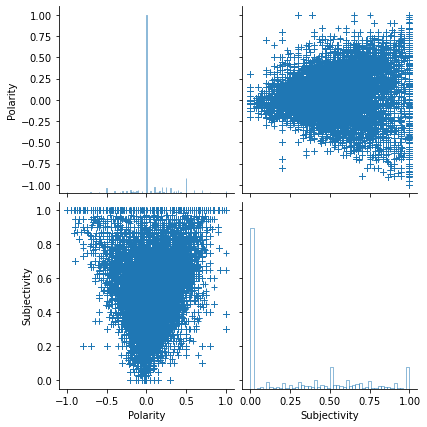

In [15]:
%matplotlib inline
sns.pairplot(all_data.loc[all_data['train_test']==1,["Polarity","Subjectivity"]],plot_kws=dict(marker="+", linewidth=1),diag_kws=dict(fill=False),
height=3)

Although the majority of observations has a polarity of 0 (neutral); corresponding to a Sentiment of 2 (agreeing with the distribution of the Sentiment distribution plot), it can clearly be noticed how the second (index 1) polarity value (0.7- positive) overestimates the  positivity of the first two sentences sentences when compared to the respective sentiment value (2- neutral). This is because polarity alone does not distinguish context nor sarcasm. The subjectivity value of 0.6 suggests a rather emotionally charged phrase. The same applies to row 6 (index 5). Notice how the presence of "A series" in the phrase does not influence polarity nor subjectivity in any way. A big reason for the frequent values of 0 afferent to both the polarity and subjectivity columns consists of the presence of rows that only have stop words in the Phrase column.

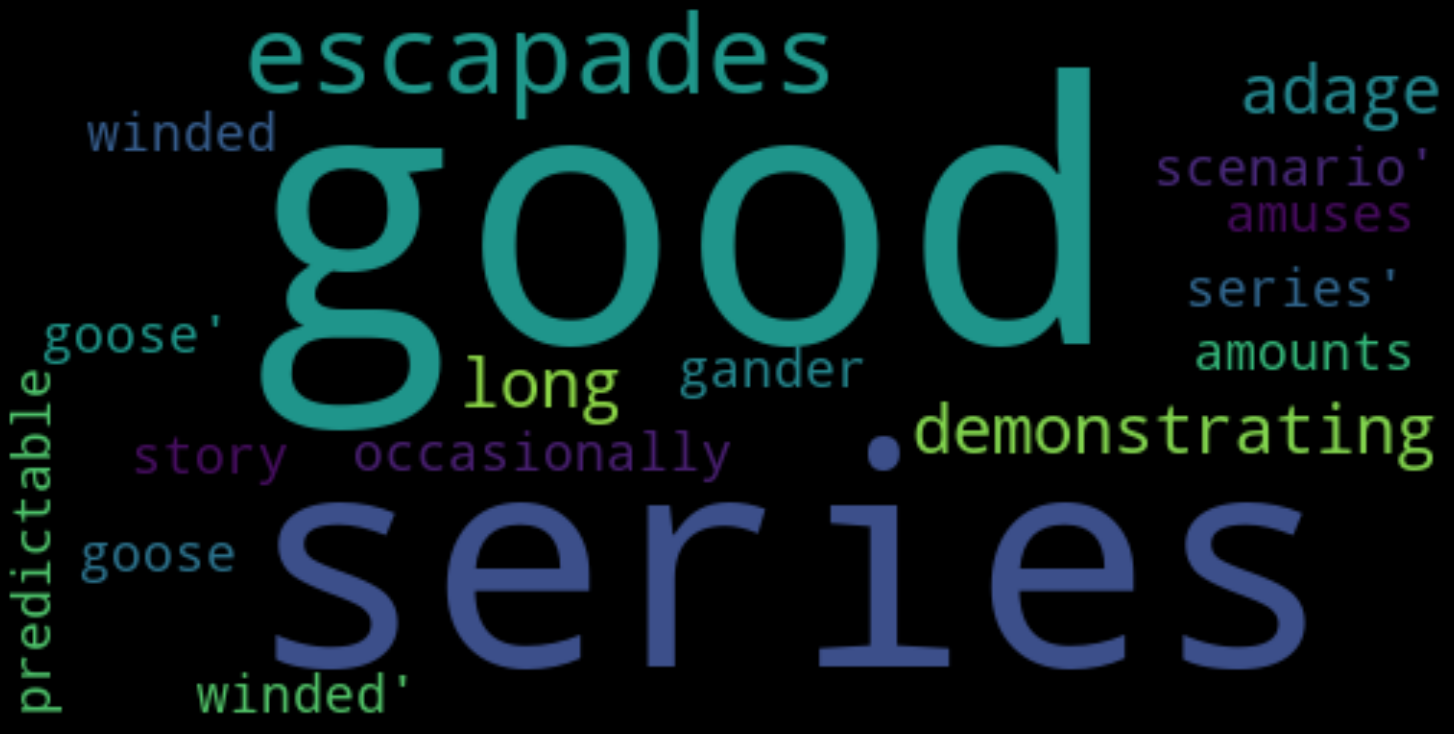

In [16]:
text = all_data.Phrase.values
wordcloud = WordCloud(
    width = 500,
    height = 250,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

According to the word cloud, the second most frequent word is "series"; which does not have neither a positive nor negative meaning. This word does not bring any added value and is repeated for most of the series reviewed on Rotten Tomatoes. This noun along with others and articles such as "a" and "the" are candidates for stop words (i.e. removing them might be beneficial).

## Pre-processing and vectorization

In [17]:
#First we clean the data

tokenized_text = all_data['Phrase'].apply(lambda x: simple_preprocess(x, deacc=True))
WNlemmatizer = WordNetLemmatizer()

tokenized_text = tokenized_text.apply(lambda x: [WNlemmatizer.lemmatize(i) for i in x])
tokenized_text.head()

0    [series, of, escapade, demonstrating, the, adage, that, what, is, good, for, the, goose, is, also, good, for, the, gander, some, of, which, occasionally, amuses, but, none, of, which, amount, to, much, of, story]
1                                                                                                                                [series, of, escapade, demonstrating, the, adage, that, what, is, good, for, the, goose]
2                                                                                                                                                                                                                [series]
3                                                                                                                                                                                                                      []
4                                                                                                                               

In [18]:
all_data['tokenized_text'] = tokenized_text

In [19]:
all_data.shape

(222352, 9)

In [20]:
all_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity,tokenized_text
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125,"[series, of, escapade, demonstrating, the, adage, that, what, is, good, for, the, goose, is, also, good, for, the, gander, some, of, which, occasionally, amuses, but, none, of, which, amount, to, much, of, story]"
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000,"[series, of, escapade, demonstrating, the, adage, that, what, is, good, for, the, goose]"
2,3,1,A series,2.0,1,2,0.0,0.00000,[series]
3,4,1,A,2.0,1,1,0.0,0.00000,[]
4,5,1,series,2.0,1,1,0.0,0.00000,[series]


[list(['series', 'of', 'escapade', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amount', 'to', 'much', 'of', 'story'])
 list(['series', 'of', 'escapade', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'])
 list(['series']) list([]) list(['series'])]


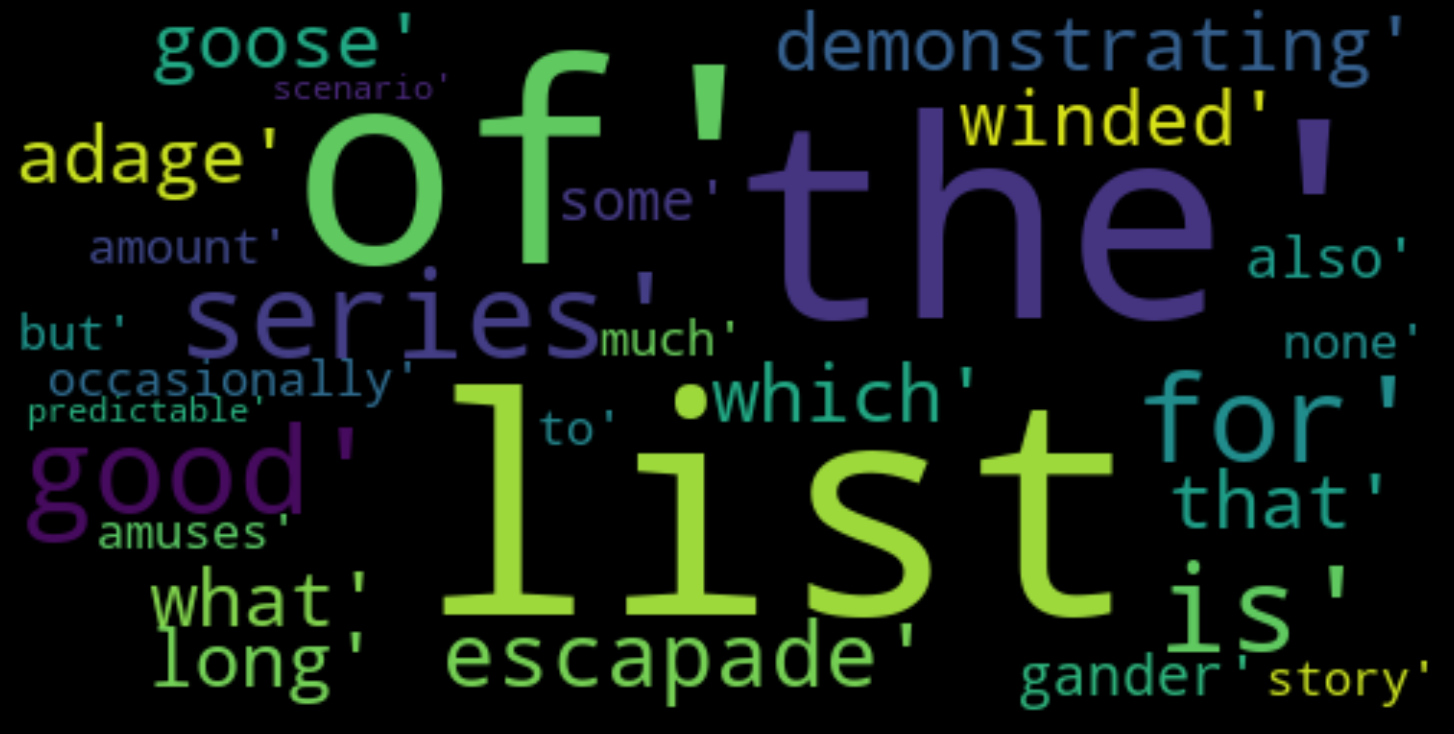

In [21]:
tokenized_text = pd.Series(all_data['tokenized_text']).values


print(tokenized_text[0:5])

wordcloud = WordCloud(
    width = 500,
    height = 250,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(tokenized_text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
import time

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        
        
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-20 20:55:39--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  51.6MB/s    in 22s     

2020-12-20 20:56:01 (71.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above

In [ ]:
# Train a bigram detector.
bigram_transformer = Phrases(tokenized_text)

# Create Skip-Gram model 
w2v_model = Word2Vec(min_count = 2,  size = 300,window = 15, workers=20,sg=1,negative=5,sample=1e-05)
w2v_model.build_vocab(tokenized_text)
#total_examples = w2v_model.corpus_count
w2v_model_0 = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
w2v_model.build_vocab([list(w2v_model_0.vocab.keys())], update=True)
w2v_model.intersect_word2vec_format(EMBEDDING_FILE, binary=True, lockf=1.0)
  
# train the w2v model
start = time.time()
w2v_model.train(bigram_transformer[tokenized_text], 
                total_examples=w2v_model.corpus_count, 
                epochs=501, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()


print("elapsed time in seconds :"+ str(end - start))            

Loss after epoch 0: 1271859.75
Loss after epoch 100: 186216.0
Loss after epoch 200: 244296.0
Loss after epoch 300: 18848.0
Loss after epoch 400: 11624.0
Loss after epoch 500: 6776.0
elapsed time in seconds :3241.945053577423


In [ ]:
words = list(w2v_model.wv.vocab)
print('Vocab size: '+str(len(words)))

Vocab size: 15806


In [ ]:
# Print results

print("Cosine similarity between 'goose' " + 
               "and 'gander' - Skip-Gram : ", 
    w2v_model.similarity('goose', 'gander')) 

print("Cosine similarity between 'story' " + 
               "and 'gander' - Skip-Gram : ", 
    w2v_model.similarity('story', 'gander')) 
      
print("Cosine similarity between 'story' " + 
               "and 'adage' - Skip-Gram : ", 
    w2v_model.similarity('story', 'gander'))

print("Cosine similarity between 'long' " + 
               "and 'winded' - Skip-Gram : ", 
    w2v_model.similarity('long', 'winded'))

Cosine similarity between 'goose' and 'gander' - Skip-Gram :  0.8457566
Cosine similarity between 'story' and 'gander' - Skip-Gram :  0.4470345
Cosine similarity between 'story' and 'adage' - Skip-Gram :  0.4470345
Cosine similarity between 'long' and 'winded' - Skip-Gram :  0.4358574


In [ ]:
# calculate: (gander - story) + goose = ?
result = w2v_model.most_similar(positive=['goose', 'gander'], negative=['story'], topn=1)
print(result)

[('demonstrating', 0.7546563148498535)]


The words 'long' and 'winded' have, as expected, the highest cosine similarity; as 'long winded' could mean 'unnecessarily long'. The 'goose' and 'gander' pair has the second highest cosine similarity with the gander being the male goose. The pairs of words 'story' and 'gander', respectively 'story' and 'adage' have much lower similarity values (which makes sense). I would, however, expect a slightly higher cosine similarity for the pairs 'long' and 'winded', respectively 'goose' and 'gander'. These estimates are mainly influenced by word pairs frequencies. For instance, because 'goose' and 'gander' appear frequently together, they have a higher similarity value. Usually, the models based on Word2vec are trained on very large corpi of text. Here, and the accuracy of the similarity estimates is mainly impacted by the size, window and negative sample size hyperparameters of the Word2Vec() estimator along with the number of epochs used to train it.

In [ ]:
w2v_model.wv.save_word2vec_format("Rotten_Tomatoes_embedding_word2vec.txt",binary=False)

In [22]:
import os

embedding_index={}
f=open(os.path.join("","Rotten_Tomatoes_embedding_word2vec.txt"),encoding="utf-8")
for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[1:])
  embedding_index[word]=coefs
f.close()

The next step is to convert the word embedding into tokenized vector. The review documents are integer encoded prior to passing them to the Embedding layer. The integer maps to the index of a specific vector in the embedding layer. Therefore, it is important that we lay the vectors out in the Embedding layer such that the encoded words map to the correct vector.

In [23]:
#First, I will separate the tokens related to the training data from the test data in order to be able to train the 
#model on the training data and test it on test data.

tokenized_text_train=tokenized_text[0:156060]
tokenized_text_test=tokenized_text[156060:]
maxlen_tokens=pd.Series(all_data.n_tokens).max()

In [24]:
#It is time to vectorise the text into a 2d interger tensor.

#First I start with the training data.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_obj_train=Tokenizer()
tokenizer_obj_train.fit_on_texts(tokenized_text_train)
sequences_train=tokenizer_obj_train.texts_to_sequences(tokenized_text_train)

#Pad sequences
word_index_train=tokenizer_obj_train.word_index
print("Found %s unique tokens."%len(word_index_train))

tokenized_text_train_pad=pad_sequences(sequences_train,maxlen=maxlen_tokens)
sentiment_train=all_data[all_data.train_test==1].Sentiment
print("Shape of sentiment tensor in training data:",sentiment_train.shape)
print("Shape of text tensor in training data:",tokenized_text_train_pad.shape)

Found 13698 unique tokens.
Shape of sentiment tensor in training data: (156060,)
Shape of text tensor in training data: (156060, 56)


In [25]:
num_words_train=len(word_index_train)+1
embedding_matrix_train=np.zeros((num_words_train,300))

for word, i in word_index_train.items():
  if i> num_words_train:
    continue
  embedding_vector=embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_train[i]=embedding_vector

In [26]:
#I'll do the same for the test data.
tokenizer_obj_test=Tokenizer()
tokenizer_obj_test.fit_on_texts(tokenized_text_test)
sequences_test=tokenizer_obj_test.texts_to_sequences(tokenized_text_test)

#Pad sequences
word_index_test=tokenizer_obj_test.word_index
print("Found %s unique tokens."%len(word_index_test))

tokenized_text_test_pad=pad_sequences(sequences_test,maxlen=maxlen_tokens)
sentiment_test=all_data[all_data.train_test==0].Sentiment
print("Shape of sentiment tensor in test data:",sentiment_test.shape)
print("Shape of text tensor in test data:",tokenized_text_test_pad.shape)

Found 8688 unique tokens.
Shape of sentiment tensor in test data: (66292,)
Shape of text tensor in test data: (66292, 56)


In [27]:
num_words_test=len(word_index_test)+1
embedding_matrix_test=np.zeros((num_words_test,300))

for word, i in word_index_test.items():
  if i> num_words_test:
    continue
  embedding_vector=embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_test[i]=embedding_vector

In [ ]:
#embedding_matrix=np.concatenate((embedding_matrix_train, embedding_matrix_test))

In [28]:
x_train_w2v = embedding_matrix_train
x_test_w2v = embedding_matrix_test

After re-shaping the training and test data, I chose to normalise the x_train_w2v and x_test_w2v. I did this in order to try to improve the overall accuracy of the model. This should help the gradient descent converge in the case of the neural network I trained after the pre-processing. Normalising improved the accuracy of the benchmark Bernoulli Naive Bayes by more than 10%. 

In [29]:
min, max = x_train_w2v.min(), x_train_w2v.max()
x_train_w2v = (x_train_w2v - min) / (max - min)

min, max = x_test_w2v.min(), x_test_w2v.max()
x_test_w2v = (x_test_w2v - min) / (max - min)

embedding_matrix=np.concatenate((x_train_w2v, x_test_w2v))

In [30]:
#It's time to split the data in training data and validation data.

val_split=0.3

indices=np.arange(tokenized_text_train_pad.shape[0])
np.random.shuffle(indices)
tokenized_text_train_pad=tokenized_text_train_pad[indices]
sentiment_train=sentiment_train[indices]
num_val_samples=int(val_split*tokenized_text_train_pad.shape[0])

x_train_pad=tokenized_text_train_pad[:-num_val_samples]
y_train=sentiment_train[:-num_val_samples]
x_val_pad=tokenized_text_train_pad[-num_val_samples:]
y_val=sentiment_train[-num_val_samples:]
x_test_pad=tokenized_text_test_pad
y_test=sentiment_test


In [31]:
print("Shape of x_train_pad tensor:",x_train_pad.shape)
print("Shape of y_train tensor:",y_train.shape)
print("Shape of x_val_pad tensor:",x_val_pad.shape)
print("Shape of y_val tensor:",y_val.shape)

Shape of x_train_pad tensor: (109242, 56)
Shape of y_train tensor: (109242,)
Shape of x_val_pad tensor: (46818, 56)
Shape of y_val tensor: (46818,)


## Developing a classifier for predicting the sentiment

I will now try to tune several RNN (LSTM) neural network architectures in order to find the best.

In [32]:
from tensorflow import keras
import IPython
!pip install -q -U keras-tuner

import tensorflow as tf
import kerastuner as kt
from keras.models import Sequential
from keras.layers import Input,Dense,Embedding,LSTM,Bidirectional,TimeDistributed
from keras.initializers import Constant
from kerastuner.tuners import BayesianOptimization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score,classification_report

     |████████████████████████████████| 71kB 4.1MB/s 


In [ ]:
num_words=num_words_train+num_words_test
max_length=maxlen_tokens

def build_model(hp):
    model = Sequential()
    model = Sequential()
    embedding_layer=Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length,
                          trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                        max_value=640,
                                        step=32), 
                    dropout=0.2, recurrent_dropout=0.2, activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='tanh'
    )))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))
    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 16,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'LSTM_1', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 16
EPOCHS = 16

bayesian_opt_tuner.search(x_train_pad, y_train,
             epochs=EPOCHS,
             validation_data=(x_val_pad,y_val),
             validation_steps=16,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal activation function is {best_hps.get('dense_activation')}. 
""")

Trial 30 Complete [00h 07m 43s]
val_accuracy: 0.5155599117279053

Best val_accuracy So Far: 0.5171223878860474
Total elapsed time: 00h 50m 31s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 288 and the optimal learning rate for the optimizer
is 0.001. The optimal activation function is selu. 



In [33]:
#I now fit the optimal model above with 1 hidden layer and supervise the evolution of accuracy per epoch.

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report
num_words=num_words_train+num_words_test
max_length=maxlen_tokens

tf.random.set_seed(0)
epochs = 39 
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
best_nn = Sequential()
embedding_layer=Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length,
                          trainable=False)
best_nn.add(embedding_layer)
best_nn.add(LSTM(units=288, dropout=0.2, recurrent_dropout=0.2,return_sequences=False, activation='selu'))
best_nn.add(Dense(5, activation='softmax'))
best_nn.compile(loss=loss,optimizer=optimizer,metrics= metrics)
best_nn.fit(x_train_pad, y_train,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_pad,y_val))

Epoch 1/39
114/114 [==============================] - 104s 886ms/step - loss: 1.5098 - accuracy: 0.4866 - val_loss: 1.2717 - val_accuracy: 0.5110
Epoch 2/39
114/114 [==============================] - 102s 896ms/step - loss: 1.2703 - accuracy: 0.5101 - val_loss: 1.2317 - val_accuracy: 0.5084
Epoch 3/39
114/114 [==============================] - 98s 863ms/step - loss: 1.2386 - accuracy: 0.5099 - val_loss: 1.2095 - val_accuracy: 0.5182
Epoch 4/39
114/114 [==============================] - 97s 854ms/step - loss: 1.2336 - accuracy: 0.5110 - val_loss: 1.2018 - val_accuracy: 0.5191
Epoch 5/39
114/114 [==============================] - 98s 858ms/step - loss: 1.2165 - accuracy: 0.5146 - val_loss: 1.1901 - val_accuracy: 0.5157
Epoch 6/39
114/114 [==============================] - 97s 849ms/step - loss: 1.2089 - accuracy: 0.5135 - val_loss: 1.1855 - val_accuracy: 0.5211
Epoch 7/39
114/114 [==============================] - 95s 834ms/step - loss: 1.2036 - accuracy: 0.5181 - val_loss: 1.1611 - val_

In [34]:
score_train=best_nn.evaluate(x_train_pad, y_train,batch_size=batch_size)
score_val=best_nn.evaluate(x_val_pad,y_val,batch_size=batch_size)
best_nn.metrics_names

49/49 [==============================] - 11s 215ms/step - loss: 1.0791 - accuracy: 0.5441


['loss', 'accuracy']

In [ ]:
num_words=num_words_train+num_words_test
max_length=maxlen_tokens

def build_model(hp):
    model = Sequential()
    embedding_layer=Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length,
                          trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=hp.Int('units',min_value=32,
                                        max_value=640,
                                        step=32), 
                    dropout=0.2, recurrent_dropout=0.2, activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='tanh'
    ))))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))
    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 16,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'LSTM_3', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 16
EPOCHS = 16

bayesian_opt_tuner.search(x_train_pad, y_train,
             epochs=EPOCHS,
             validation_data=(x_val_pad,y_val),
             validation_steps=16,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal activation function is {best_hps.get('dense_activation')}. 
""")

Trial 30 Complete [00h 06m 32s]
val_accuracy: 0.04407552257180214

Best val_accuracy So Far: 0.5174478888511658
Total elapsed time: 01h 28m 46s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 160 and the optimal learning rate for the optimizer
is 0.001. The optimal activation function is relu. 



In [ ]:
#I now fit the optimal model above with 1 hidden layer and supervise the evolution of accuracy per epoch.

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

num_words=num_words_train+num_words_test
max_length=maxlen_tokens


tf.random.set_seed(0)
epochs = 64 
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = Sequential()
embedding_layer=Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length,
                          trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units=160, dropout=0.2, recurrent_dropout=0.2,return_sequences=False, activation='relu')))
model.add(Dense(5, activation='softmax'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_pad, y_train,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_pad,y_val))

Epoch 1/64
114/114 [==============================] - 131s 1s/step - loss: 1.3476 - accuracy: 0.4896 - val_loss: 1.2703 - val_accuracy: 0.5142
Epoch 2/64
114/114 [==============================] - 129s 1s/step - loss: 1.2730 - accuracy: 0.5079 - val_loss: 1.2347 - val_accuracy: 0.5142
Epoch 3/64
114/114 [==============================] - 131s 1s/step - loss: 1.2451 - accuracy: 0.5106 - val_loss: 1.2220 - val_accuracy: 0.5180
Epoch 4/64
114/114 [==============================] - 130s 1s/step - loss: 1.2316 - accuracy: 0.5114 - val_loss: 1.1978 - val_accuracy: 0.5195
Epoch 5/64
114/114 [==============================] - 131s 1s/step - loss: 1.2195 - accuracy: 0.5123 - val_loss: 1.1927 - val_accuracy: 0.5206
Epoch 6/64
114/114 [==============================] - 129s 1s/step - loss: 1.2179 - accuracy: 0.5126 - val_loss: 1.1774 - val_accuracy: 0.5231
Epoch 7/64
114/114 [==============================] - 131s 1s/step - loss: 1.2045 - accuracy: 0.5164 - val_loss: 1.1707 - val_accuracy: 0.5225

In [ ]:
score_train=model.evaluate(x_train_pad, y_train,batch_size=batch_size)
score_val=model.evaluate(x_val_pad,y_val,batch_size=batch_size)
model.metrics_names

49/49 [==============================] - 10s 208ms/step - loss: 1.0599 - accuracy: 0.5504


['loss', 'accuracy']

## Fitting the final model on the test data and making the submission

The best model in terms of the bias-variance trade-off (with a validation accuracy of 54.41%)  consists of the uni-directional LSTM neural network architecture. Because the increase in accuracy as a result of using a bi-directional LSTM architecture is small, I opted for the less complex model (the uni-directional LSTM). The accuracy of the model on test data (after submitting the answer to Kaggle) is only 52.36%. This is mainly due to the highly unbalanced training and test datasets that mostly contain neutral reviews (mainly incomplete sentences with sentiment values of 2) along with the relatively small number of words used in training the model.

In [39]:
best_neural_network_pred = pd.DataFrame(best_nn.predict_classes(x_test_pad),columns=["Sentiment"])

#convert output to dataframe 
final_data = {'PhraseId': test.PhraseId, 'Sentiment': best_neural_network_pred.Sentiment}

In [42]:
submission_1 = pd.DataFrame(data=final_data)
submission_1.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [37]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [41]:
submission_1.to_csv("/content/drive/MyDrive/Rotten tomatoes/Rotten_Tomatoes_sentiment_classification_submission_lstm.csv",index=False)